In [14]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tqdm

plt.style.use('ggplot')

torch.manual_seed(0)   #You can use torch.manual_seed() to seed the RNG for all devices (both CPU and CUDA)
random.seed(0)         #For custom operators, you might need to set python seed
np.random.seed(0)      #If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG

In [15]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.3, random_state=True)

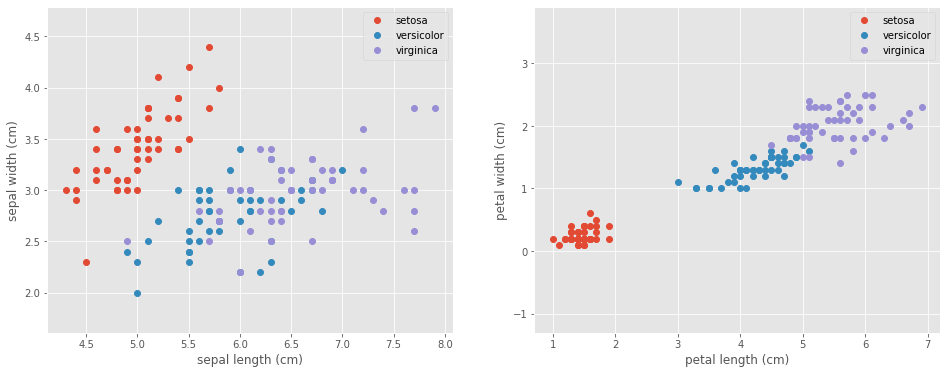

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [17]:
class DNN_LITE(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(DNN_LITE, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        nn.BatchNorm1d(50)
        self.layer2 = nn.Linear(50, 50)
        nn.BatchNorm1d(50)
        self.layer3 = nn.Linear(50, out_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=0)
        return x

In [18]:
model     = DNN_LITE(Xtrain.shape[1],len(names))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

DNN_LITE(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [29]:
from torchsummary import summary
model = DNN_LITE(4,3).cuda()
summary(model,(1,4)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             250
            Linear-2                [-1, 1, 50]           2,550
            Linear-3                 [-1, 1, 3]             153
Total params: 2,953
Trainable params: 2,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [19]:
EPOCHS  = 100
X_train = Variable(torch.from_numpy(Xtrain)).float()
y_train = Variable(torch.from_numpy(ytrain)).long()
X_test  = Variable(torch.from_numpy(Xtest)).float()
y_test  = Variable(torch.from_numpy(ytest)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 933.92it/s]


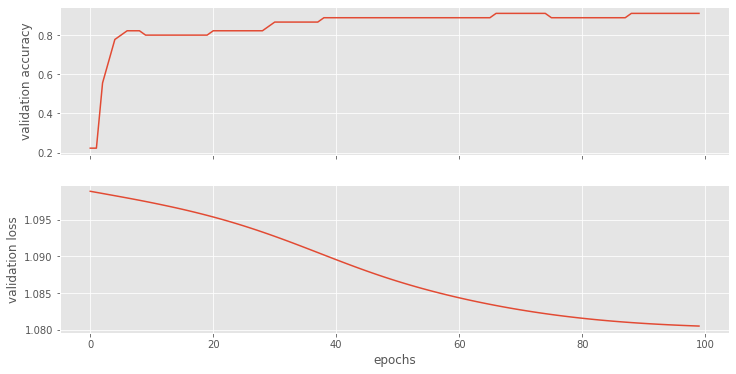

In [20]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

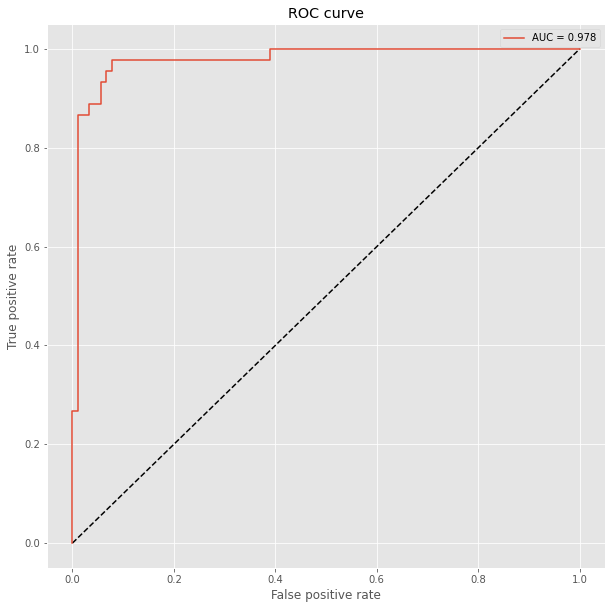

In [21]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [22]:
# Prediction
my_test = Variable(X_test).float()
pred = model(my_test)
pred = pred.cpu().detach().numpy()
pred

array([[9.6612222e-02, 1.9383954e-04, 4.6650398e-06],
       [6.4123241e-04, 1.4291824e-01, 3.7461617e-05],
       [1.3659569e-04, 5.1527093e-03, 1.6062135e-03],
       [7.3481709e-02, 2.7953694e-04, 5.4807742e-06],
       [8.2534380e-06, 4.6793695e-05, 3.8391933e-01],
       [1.0459071e-04, 2.2464874e-03, 3.6870544e-03],
       [1.9347519e-05, 3.5379906e-04, 5.5464808e-02],
       [5.8002338e-02, 3.9664863e-04, 5.9586196e-06],
       [5.4849118e-02, 7.8260398e-04, 4.0796986e-06],
       [1.4205389e-05, 2.3730722e-04, 1.0195694e-01],
       [2.2227454e-04, 5.5060178e-02, 1.9956761e-04],
       [6.0717419e-02, 3.4088831e-04, 6.2291861e-06],
       [1.6901169e-05, 3.7540527e-04, 6.7324094e-02],
       [1.3110835e-04, 3.2938928e-03, 2.2756644e-03],
       [1.3795207e-04, 1.1095573e-02, 8.9418516e-04],
       [8.4619932e-02, 5.3419871e-04, 2.9180158e-06],
       [2.7582300e-04, 9.4724014e-02, 1.1758275e-04],
       [1.5538010e-04, 1.1680005e-02, 8.0857426e-04],
       [2.7733961e-02, 1.086

In [23]:
print ("The accuracy is", accuracy_score(y_test, np.argmax(pred, axis=1)))

The accuracy is 0.9111111111111111


In [24]:
my_test = Variable(X_test[40]).float()
pred = model(my_test)
pred0 = pred.cpu().detach().numpy()
pred1 = np.argmax(pred0, axis=0)
pred1

2

In [25]:
ytest[40]

2

In [ ]:
torch.save(model.state_dict(), 'DNN_lite.pth')